# Tutorial: Use cnmfe-reviewer to train and predict on your own data

This tutorial will walk you through training our classifiers on your data and using those finetuned models to label your unlabeled data. We will be using our 1p ground truth dataset (from mouse hippocampal CA1) to walk you through the steps. 

## Table of Contents
- [Getting started](#Getting-started)
    - [What is `cnmfe-reviewer`?](#What-is-cnmfe-reviewer)
    - [Prerequisites](#Prerequisites)
    - [Configure the settings](#Configure-the-settings-in-config.py)
- [Manual ROI Review](#Manual-ROI-Review)
    - [Using review_traces.py](#Using-review_traces.py)
    - [Using your own method](#Using-your-own-method)
- [When should you retrain your model](#retraining-the-model)
- [Finetune the saved models on your own data](#Training-the-classifiers-on-your-own-data)
- [Apply classifiers to your unlabeled data](#Apply-classifiers-to-unlabeled-data)

## Getting started

### What is cnmfe-reviewer

`cnmfe-reviewer` is a Python package for combining automated machine learning (AutoML) with an intitial manual labeling step to assist in curation of identified ROIs by the [CNMF-E algorithm (Zhou et al 2016)](https://elifesciences.org/articles/28728) from 1p calcium imaging recordings.

The general steps in using this tool are as follows:
1. Run your videos through CNMF-E using parameters that have worked for you.
2. Create your training data set by manually labeling ~1200 ROIs to identify false positives identified by CNMF-E. 
3. Use `collect_data.py` to aggregate the spatial footprints, traces and labels (keep or exclude) for your labeled ROIs to preprocess the data for the AutoML classifier.
4. Import the AutoSklearn ensemble and fit it on your training data, setting aside ~200 for validation that the trained model is accurately predicting on your data. 
**NOTE: You only need to do this once per set of experiments** (see this section on ["Retraining the model"](#retraining-the-model)
5. After you've trained the model to specifically recognize your data once, you can now export that pretrained model and use it to predict and curate all of your unlabeled 1p data in the future, without any further training. 


### Installation

The installation guide is provided in the [GitHub Repository README](https://github.com/jf-lab/cnmfe-reviewer#installation).

### Prerequisites
1. You've run your recordings through [CNMF-E](https://github.com/zhoupc/CNMF_E)
2. You have the `.mat` output files with the identified ROIs (raw/deconvolved traces, footprints, calcium events, and other metadata). 
2. You have used `review_traces.py` or [another method (see notes below)](#manual-roi-review) to manually review and curate "good"/"bad" ROIs from CNMF-E (around ~1200 manually labelled ROIs to start).
    - whatever method you use, you should now have a "targets" file that contains your manually curated labels which can be loaded as a 1-d array of size `N` (total number of reviewed/labelled ROIs) 
    - We have found that the model works best with **at least 1000 labeled ROIs** to train on. 
    - You should set aside at least another **100-200 to validate the results** before applying on your unlabeled data.


### Configure the settings in config.py

To set your experimental metadata, edit the settings in `config.py`. A template `config.py` is provided in the repository for you. Also, since every imaging setup for every experiment are slightly different in terms of video image dimensions, you will need to set those dimensions for the spatial footprints so the data preprocessing steps can work properly. 

If you make a copy of this notebook and move it somewhere else, you will want to make sure there is a `config.py` in the same directory as the notebook so that it can be imported, or you can choose to just run the file with `%run -i /path/to/config.py`. 

## Manual ROI Review
### Using review_traces.py
You may wish to use our `review_traces.py` [Python script](https://github.com/jf-lab/chendoscope-minipipe/blob/master/review_traces.py) that aggregates your ROIs into an GUI so you can scan through the calcium traces and spatial footprints for each ROI identified by CNMF-E and label whether you would keep or exclude the ROIs in further analyses steps. 

![Screenshot of the review_traces.py GUI](./review_cnmfe.png) 

This script will add an array in your `.mat` file named `keep` that stores the indices of the ROIs that you labeled to `keep`. 

You can also use the [Python script](https://github.com/jf-lab/chendoscope-minipipe/blob/master/apply_reviews.py) `apply_review.py` which reads your `.mat` file and creates a new copy (same filename with `_keep.mat` appended to the end) which only contains the ROIs you labeled as "keep" in the original file. 

We use this same script to apply the predictions from our automl models as well and the steps to do so will be shown towards the end of this tutorial.

Steps:
```
# to open the GUI
python review_traces.py results_file.mat 

# assess the quality of your ROIs and use 'j' to exclude, 'k' to keep, 'u' to undo

# when done, close the window, then run:
python apply_reviews.py results_file.mat
```
You should now have a new file named `results_file_keep.mat` that has only the cells you labeled `keep`. 


### Using your own method

You may have already amassed your own dataset of labeled ROIs that you have manually reviewed. In order to use it with these automl tools, you'll need a `targets` array to go along with your data that fits these requirements:

- a 1d array comprised of only `0` and `1` that is the same size as the number of ROIs you have in your dataset (e.g. if you have labeled 1300 cells output by cnmf-e, your targets array should also be 1300 values long, in the same order as your actual data)
- the order needs to match the occurence of ROIs in your dataset, such that the position of a `0` denotes the position of the ROI which you labeled as "excluded", and `1` denotes an ROI you labeled as "keep". 

## Retraining the model

Here are some factors to consider when training your classifier, so that you can use it in the future to label new data without having to retrain it.

### Dimensions/shape of the data
The classifiers can only predict on data that are of the same dimensions as the data it was trained on. So if your cropped images in the training set are 50x50 pixels, and your traces are cropped to 500 frames long, all subsequent unlabeled data that you feed through the model for curation will need to also match these dimensions. 

### Similarity of the spatial footprints between experiments
If the first dataset you trained your classifier on mostly saw neurons of a certain size and shape (e.g. all roughly with a radius of 20 pixels), it is possible that another experimental dataset where all the spatial footprints are much larger or much smaller, that these may factor into whether you should again manually label some of these differently sized ROIs and add them to your training dataset and retrain your model to be able to recognize these patterns. 

# Training the classifiers on your own data

In [8]:
# import packages

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import cnmfereview as cr
import config as cfg
import os
from joblib import dump, load

In [11]:
MODELDIR = Path('../best_models')

Have you already trained your model and just want to predict? Skip to [Apply Classifiers to Unlabeled Data](#Apply-classifiers-to-unlabeled-data)

## Load your data

In [10]:
data = cr.Dataset(
    data_paths=cfg.data_paths,
    exp_id=cfg.exp_id,
    img_shape=cfg.img_shape,
    img_crop_size=cfg.img_crop_size,
    max_trace=cfg.max_trace_len,
    )

No preprocessing on spatial data
File /home/lina/Documents/Lab/Projects/cnmfe-reviewer/data/cr_tutorialA_cropped.npy already exists and has been loaded instead.
No preprocessing on trace data.                   /home/lina/Documents/Lab/Projects/cnmfe-reviewer/data/cr_tutorialCraw_normalized.npy already                   exists and has been loaded instead.


In [4]:
x_train, x_test, y_train, y_test = data.split_training_test_data(
    test_split=.20,
    seed=10
)

Training and test data loaded


_________________
**NOTE: Remove the next cell when training your own models.** This step uses fewer ROIs (only ~3000 instead of 11 000) in the tutorial dataset to speed up computation in the tutorial. Do not do this when you are training your own data. You want to use as many data samples as possible to get the best results in practice. 

In [5]:
# remove or comment out this cell when using on your own data
from sklearn.model_selection import train_test_split
x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.75)

____________________________

In [6]:
print(f"Number of samples in training set: {x_train.shape[0]}") 
print(f"Number of samples in test set: {x_test.shape[0]}")


Number of samples in training set: 2900
Number of samples in test set: 2901


# Train the saved models on your data

# TPOT Classifier

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score

In [10]:
from sklearn.svm import LinearSVC

# this was the final TPOT exported pipeline that acheived the highest F1 score
tpot_model = LinearSVC(C=0.1, dual=False, loss="squared_hinge", penalty="l1", tol=0.1)


In [11]:
tpot_model.fit(x_train, y_train)

LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l1', random_state=None, tol=0.1,
          verbose=0)

In [12]:
tpot_y_pred = tpot_model.predict(x_train)

In [13]:
print("Accuracy:", accuracy_score(y_train, tpot_y_pred))
print("f1:", f1_score(y_train, tpot_y_pred))

Accuracy: 0.8758620689655172
f1: 0.9104477611940298


Save a copy of the model finetuned on your data to use again in the future to predict without having to retrain.

In [14]:
dump(tpot_model, MODELDIR / f'{cfg.exp_id}_tpot.joblib') 

['../best_models/cnmfereview_tutorial_tpot.joblib']

# AutoSklearn Classifier

In [4]:
import autosklearn
import sklearn

In [7]:
# load the AutoSklearn ensemble object
askl = load(MODELDIR / 'cr_tutorial_askl.joblib')

In [17]:
askl.refit(x_train, y_train)

AutoSklearnClassifier(delete_output_folder_after_terminate=False,
                      delete_tmp_folder_after_terminate=False,
                      disable_evaluator_output=False,
                      ensemble_memory_limit=5000, ensemble_nbest=50,
                      ensemble_size=100, exclude_estimators=None,
                      exclude_preprocessors=None, get_smac_object_callback=None,
                      include_estimators=None, include_preprocessors=None,
                      initial_configurati...
                      resampling_strategy=<class 'sklearn.model_selection._split.RepeatedStratifiedKFold'>,
                      resampling_strategy_arguments={'folds': 5, 'n_repeats': 5,
                                                     'random_state': 23},
                      seed=1, shared_mode=False, smac_scenario_args=None,
                      time_left_for_this_task=108720,
                      tmp_folder=PosixPath('/home/linatran/cnmfereview/models/autosklearn/

In [18]:
results_automl = askl.predict(x_test)

In [19]:
print("Accuracy:", accuracy_score(y_test, results_automl))
print("f1:", f1_score(y_test, results_automl))

Accuracy: 0.8772836952774905
f1: 0.9074844074844074


In [6]:
dump(askl, MODELDIR / f'{cfg.exp_id}_askl.joblib')

['../best_models/cr_tutorial_askl.joblib']

# Apply classifiers to unlabeled data

In [15]:
askl = load(MODELDIR / f'{cfg.exp_id}_askl.joblib');
tpot_model = load(MODELDIR / f'{cfg.exp_id}_tpot.joblib')

In [3]:
unseen_data = cr.UnlabeledDataset(
    mat_file='../data/unlabeled_rois.mat',
    img_shape=cfg.img_shape,
    img_crop_size=cfg.img_crop_size,
    max_trace=cfg.max_trace_len)

Sucessfully loaded data. There are 25 ROIs                in this .mat file.
Spatial footprints cropped, and traces normalized and cropped.


In [5]:
pred_askl = askl.predict(unseen_data.combined)

In [6]:
pred_tpot = tpot_model.predict(unseen_data.combined)

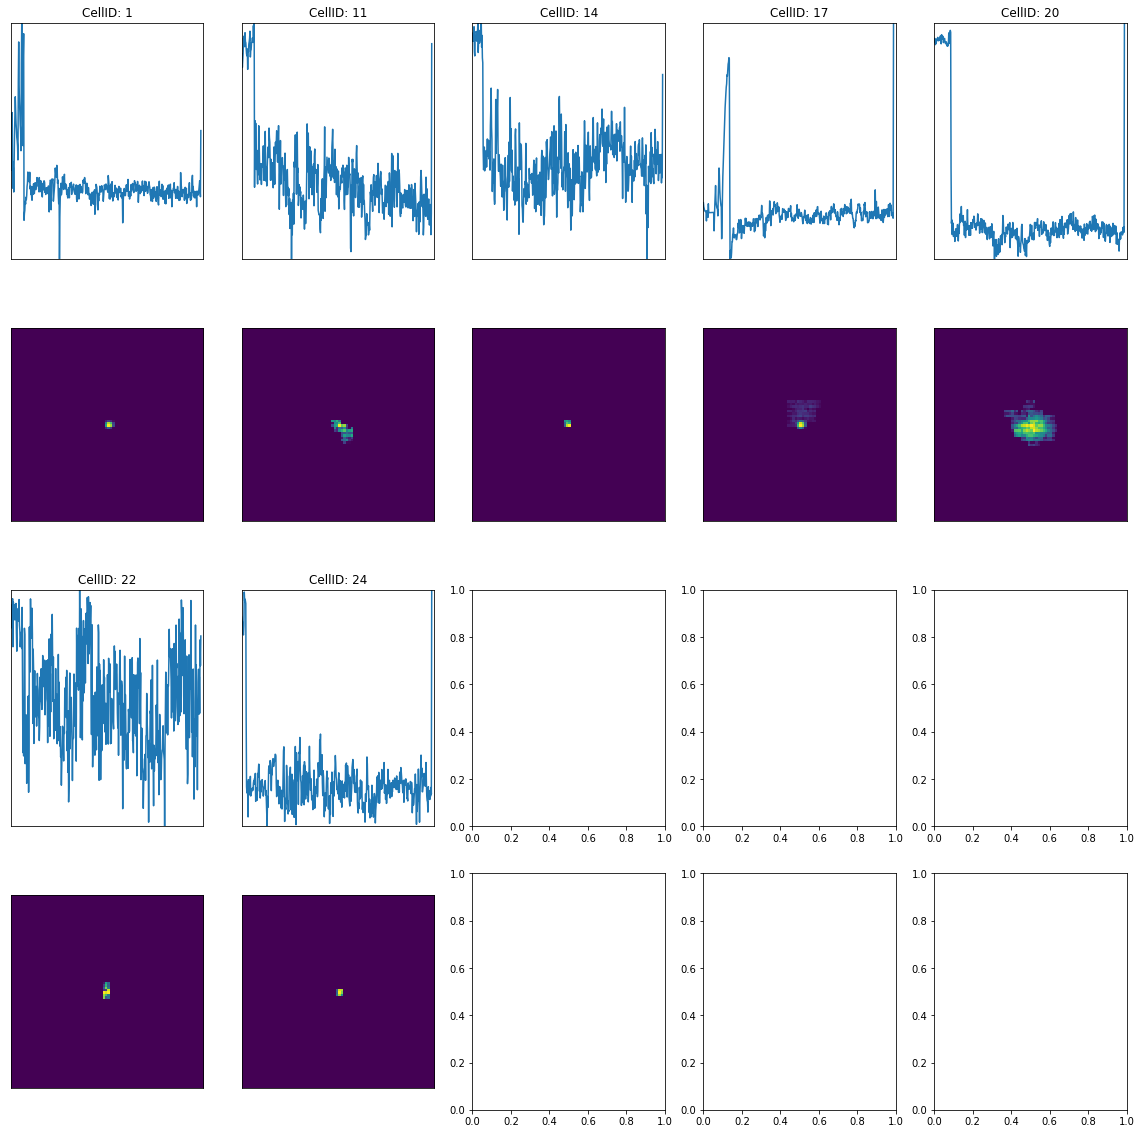

In [11]:
# preview the ROIs labeled by askl as "negatives"
negative_askl = np.where(pred_askl==0)[0]
# limit to only show 10 at once, you can play around with this of course
cr.plot_rois(unseen_data, negative_askl[:10])

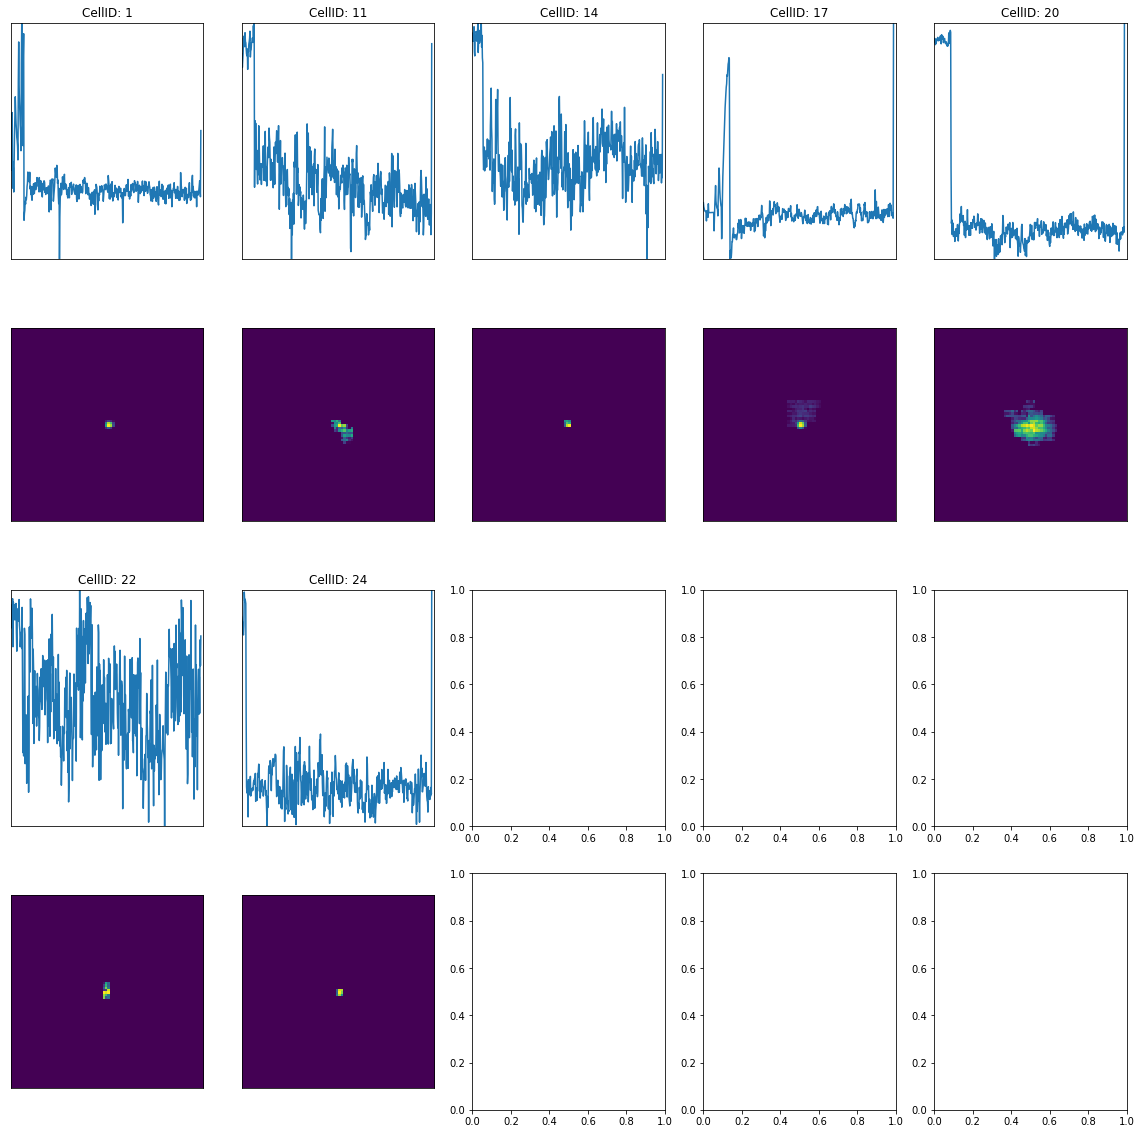

In [13]:
# preview the ROIs labeled by TPOT as "negatives"
cr.plot_rois(unseen_data, np.where(pred_tpot==0)[0][:10])

# Apply reviews

In [ ]:
unseen_data.apply_labels(pred_askl)

In [14]:
# load the file to check the results
from scipy.io import loadmat, savemat

labeled_data = loadmat('../data/unlabeled_rois_automl.mat')


(18, 1800)